In [1]:
import math
import itertools
from collections.abc import Iterable, Collection
from numbers import Number
from typing import Tuple, List, Union

import yaml

import numpy as np

%matplotlib widget
import matplotlib
import matplotlib.axes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [11]:
test_points = []

# Front
test_points.append(
    np.stack([1.5*np.ones(10), np.linspace(-0.5, 0.5, 10)], axis=-1)
)

# Back
test_points.append(
    np.stack([-1.5*np.ones(10), np.linspace(-0.25, 0.75, 10)], axis=-1)
)

# Top Right
test_points.append(
    np.stack([1*np.ones(5), np.linspace(0.75, 1.0, 5)], axis=-1)
)

test_points.append(
    np.stack([np.linspace(1.0, 1.25, 5), 0.75*np.ones(5), ], axis=-1)
)

# Bot left
test_points.append(
    np.stack([-1*np.ones(5), np.linspace(-0.75, -0.25, 5)], axis=-1)
)

test_points.append(
    np.stack([np.linspace(-1.0, -0.75, 5), -0.75*np.ones(5), ], axis=-1)
)

test_points = np.concatenate(test_points, axis=0)

In [12]:
def format_axes(ax, xlim = None, ylim = None):

    ax.set_xlabel('x')
    ax.set_ylabel('y')

    if xlim is not None:
        ax.set_xlim(xlim)

    if ylim is not None:
        ax.set_ylim(ylim)

    ax.grid()

In [13]:
def plot_map_points(ax, points, **kwargs):
    ax.scatter(points[:,0], points[:,1], **kwargs)

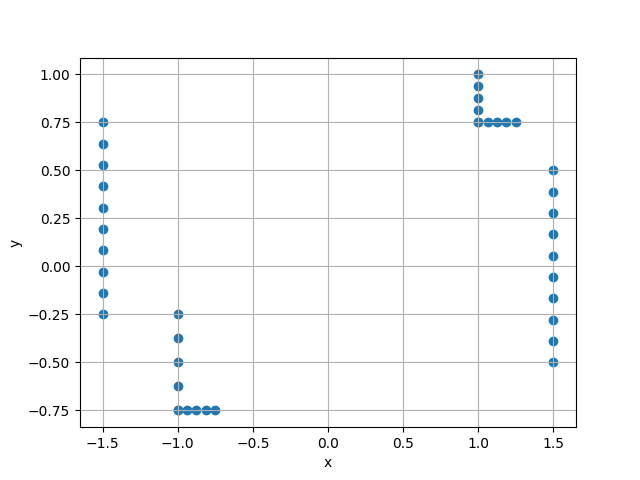

In [14]:
fig1 = plt.figure()
ax1 = fig1.gca()
plot_map_points(ax1, test_points)
format_axes(ax1)

In [18]:
class Mapper:
    def __init__(self):
        self.map_x_low = -0.25
        self.map_x_high = 2.25

        self.map_y_low = -0.25
        self.map_y_high = 2.25

        self.map_division_count = 20

        self.reset_map()

    def reset_map(self):

        self.map_x_range = self.map_x_high - self.map_x_low
        self.map_y_range = self.map_y_high - self.map_y_low

        self.map_x_cell_size = self.map_x_range / self.map_division_count
        self.map_y_cell_size = self.map_y_range / self.map_division_count
        
        self.map_corner_phi = np.arctan2(self.map_y_cell_size, self.map_x_cell_size)

        self.map_x_bounds = np.arange(
            self.map_x_low, self.map_x_high + (self.map_x_cell_size/2), self.map_x_cell_size
        )
        self.map_x_bounds_expanded = np.expand_dims(self.map_x_bounds, -1)

        self.map_y_bounds = np.arange(
            self.map_y_low, self.map_y_high + (self.map_y_cell_size/2), self.map_y_cell_size
        )
        self.map_y_bounds_expanded = np.expand_dims(self.map_y_bounds, -1)

        self.map_bounds = np.stack(np.meshgrid(self.map_x_bounds, self.map_y_bounds), -1)
        self.map_centers = self.map_bounds[:-1, :-1] + np.array([[[self.map_x_cell_size/2, self.map_y_cell_size/2]]])

        self.map = 0.5 * np.ones((self.map_division_count, self.map_division_count))

    def get_grid_index(self, points) -> Tuple[np.ndarray, np.ndarray]:
        """
        Returns
        -------

        N x 2
        """

        # Take in points in local frame
        # Returns grid index + valid points

        x_slot = np.logical_and(self.map_x_bounds_expanded[:-1] < points[:,0], points[:,0] <= self.map_x_bounds_expanded[1:])
        y_slot = np.logical_and(self.map_y_bounds_expanded[:-1] < points[:,1], points[:,1] <= self.map_y_bounds_expanded[1:])

        point_valid_mask = np.logical_and(np.any(x_slot, axis=0), np.any(y_slot, axis=0))

        grid_index = np.zeros_like(points, dtype=int)
        x_index, point_index_x = np.where(x_slot)
        grid_index[point_index_x, 0] = x_index

        y_index, point_index_y = np.where(y_slot)
        grid_index[point_index_y, 1] = y_index

        valid_indices = grid_index[point_valid_mask]
        return valid_indices, point_valid_mask

In [19]:
mapper = Mapper()

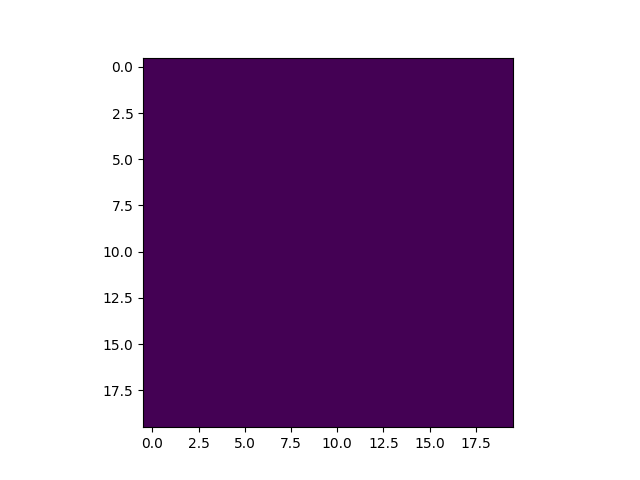

In [20]:
fig2 = plt.figure()
ax2 = fig2.gca()
ax2.imshow(mapper.map)

In [34]:
point_grid_indices, valid_mask = mapper.get_grid_index(test_points)

valid_points = test_points[valid_mask]

collide_grid = np.zeros_like(mapper.map_centers[..., 0], dtype=bool)


In [35]:
collide_grid[point_grid_indices[:,1], point_grid_indices[:,0]] = True

In [30]:
point_grid_indices

array([[13,  0],
       [13,  1],
       [13,  2],
       [13,  3],
       [13,  4],
       [13,  5],
       [13,  5],
       [ 9,  7],
       [ 9,  8],
       [ 9,  8],
       [ 9,  9],
       [ 9,  9],
       [ 9,  7],
       [10,  7],
       [10,  7],
       [11,  7],
       [11,  7]])

In [32]:
collide_grid

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [Fa

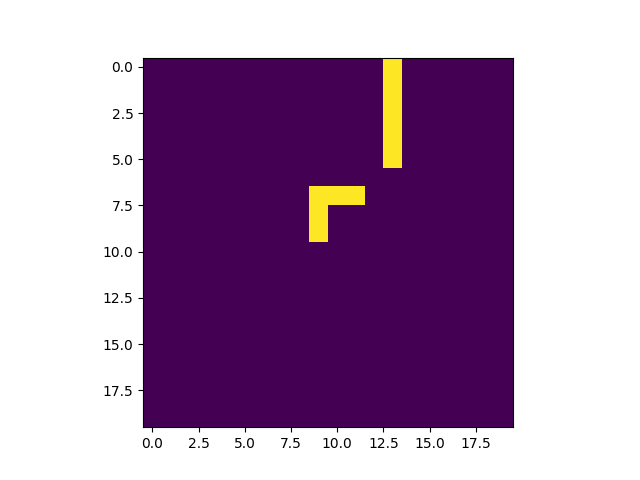

In [36]:
fig3 = plt.figure()
ax3 = fig3.gca()
ax3.imshow(collide_grid)